<a href="https://colab.research.google.com/github/dmytro-varich/Texture-Segmentation-App/blob/main/segmentation_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
#Jacob Gildenblat, 2015
#Implementation of edge preserving smoothing by minimizing with the Ambrosio-Tortorelli appoach
#AM scheme, using conjugate gradients
import cv2, scipy
import numpy as np
import sys
import scipy
from scipy.sparse.linalg import LinearOperator

class AmbrosioTortorelliMinimizer():
	def __init__(self, img, iterations = 1, solver_maxiterations = 10, tol = 0.1, alpha = 1000, beta = 0.01, epsilon = 0.01):
		self.iterations = iterations
		self.tol = tol
		self.g = np.float64(img) / np.max(img)
		self.f = self.g
		self.edges = np.zeros(img.shape)
		self.update_gradients()
		self.alpha, self.beta, self.epsilon = alpha, beta, epsilon
		self.add_const = self.beta / (4 * self.epsilon)
		self.multiply_const = self.epsilon * self.beta
		self.maxiter = solver_maxiterations

	def update_gradients(self):
		self.grad_x, self.grad_y = self.gradients(self.f)
		self.gradient_mag = np.power(self.grad_x, 2) + np.power(self.grad_y, 2)

	def edge_linear_operator(self, input):
		v = input.reshape(*self.g.shape)
		result = np.multiply(v, self.gradient_mag * self.alpha + self.add_const) \
				- self.multiply_const* cv2.Laplacian(v, cv2.CV_64F)

		return result.reshape(*input.shape)

	def image_linear_operator(self, input):
		f = input.reshape(*self.g.shape)

		x, y = self.gradients(f)

		result = f - 2*self.alpha * (self.calc_grad_x(np.multiply(self.edges, x)) + self.calc_grad_y(np.multiply(self.edges, y)) )
		return result.reshape(*input.shape)

	def solve_edges(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.edge_linear_operator, dtype = np.float64)
		b = np.ones(size) * self.beta / (4 * self.epsilon)

		self.edges, _ = scipy.sparse.linalg.cg(A, b, rtol = self.tol, maxiter = self.maxiter)
		self.edges = np.power(self.edges.reshape(*self.g.shape), 2)
		return self.edges

	def solve_image(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.image_linear_operator, dtype = np.float64)
		b = self.g.reshape(size)

		self.f, _ = scipy.sparse.linalg.cg(A, b, rtol = self.tol, maxiter = self.maxiter)
		self.f = self.f.reshape(*self.g.shape)
		self.update_gradients()
		return self.f

	def minimize(self):
		for i in range(0, self.iterations):
			self.solve_edges()
			self.solve_image()

		self.edges = np.power(self.edges, 0.5)
		cv2.normalize(self.f, self.f ,0,255,cv2.NORM_MINMAX)
		cv2.normalize(self.edges, self.edges ,0,255,cv2.NORM_MINMAX)
		self.f = np.uint8(self.f)
		self.edges = 255 - np.uint8(self.edges)

		return self.f, self.edges

	def calc_grad_x(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]))

	def calc_grad_y(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]).T)

	def gradients(self, img):
		return self.calc_grad_x(img), self.calc_grad_y(img)

In [111]:
!pip install -U cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-ba5lwcrk
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-ba5lwcrk
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [112]:
!pip install PyWavelets

In [113]:
!pip install scikit-learn-extra

In [114]:
# Standard libraries
import os
from typing import Union, Dict, Tuple, List, Any, Optional

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

# PyWavelet library
import pywt

# skimage libraries
from skimage import io
from skimage.filters.rank import entropy
from skimage.filters import gaussian
from skimage.morphology import closing, square
from skimage.feature import graycomatrix, graycoprops

# sklearn libraries
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, kmeans_plusplus, BisectingKMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from skimage.feature import hog

# scipy libraries
from scipy.ndimage import median_filter

# pydensecrf library
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

In [115]:
class FileHandlerMixin:
    """
    A mixin class to provide functionality for loading and saving images.
    """
    @staticmethod
    def load_images(directory: str) -> Dict[str, np.ndarray]:
        """
        Load all images from the specified directory and return them as a dictionary.

        Parameters:
        -----------
        directory : str
            The path to the directory containing images.

        Returns:
        --------
        Dict[str, np.ndarray]
            A dictionary where keys are filenames and values are images.
        """
        images = dict()

        if not os.path.isdir(directory):
            raise ValueError(f"The specified directory '{directory}' does not exist or is not a valid directory.")

        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
                try:
                    image = io.imread(file_path)
                    images[filename] = image
                except Exception as e:
                    print(f"Failed to read '{filename}': {e}")

        return images

    @staticmethod
    def save_segmented_images(directory: str, segmented_images: Dict[str, np.ndarray], tag: str = 'seg') -> None:
        """
        Save segmented images to a specified directory, modifying filenames with a given tag.

        Parameters:
        -----------
        directory : str
            The target directory to save the images.
        segmented_images : Dict[str, np.ndarray]
            A dictionary of filenames and segmented images.
        tag : str, optional, default 'seg'
            The tag to replace 'tg' in filenames.

        Returns:
        --------
        None
        """
        os.makedirs(directory, exist_ok=True)

        for filename, image in segmented_images.items():
            new_filename = filename.replace('tg', tag)
            file_path = os.path.join(directory, new_filename)

            try:
                imageio.imwrite(file_path, image)
            except Exception as e:
                print(f"Error saving image '{new_filename}': {e}")

In [116]:
class ImageVizualizationMixin:
    """
    A mixin class to provide functionality for displaying images.
    """
    @staticmethod
    def show_images(
        images: Dict[str, np.ndarray],
        *,
        rows: int,
        cols: int,
        figsize: Tuple[int, int] = (15, 10),
        cmap: Optional[str],
        show_ax: str = 'on'
    ) -> None:
        # Create a subplot grid with the specified number of rows and columns
        fig, axes = plt.subplots(rows, cols, figsize=figsize)

        # If there is only one axis (for example, when rows=1 and cols=1)
        if rows == 1 and cols == 1:
            axes = [axes]
        else:
          axes = axes.flatten()  # Flattening the axes to 1D array

        # Iterate over the axes and images to display them
        for ax, (title, image) in zip(axes, images.items()):
            # Create a copy of the image for normalization
            img = image * 1
            # Ensure img is a numpy array
            img = np.asarray(img)
            # Normalize the image to the range [0, 255]
            # Modified to handle float32 images with cv2.normalize
            if img.dtype == np.float32:  # Check if dtype is float32
                img = (img * 255).astype(np.uint8) # Scale to 0-255 and convert to uint8
            else:
                cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)  # Existing code for other types
            # Convert the image to uint8 format for display
            img = np.uint8(img)
            # Display the image
            ax.imshow(img, cmap=cmap)
            # Set the title of the image
            ax.set_title(title)
            # Hide or show axes depending on 'show_ax' argument
            ax.axis(show_ax)

        # Adjust layout to make the plot elements fit neatly
        plt.tight_layout()

        # Display the plot
        try:
            plt.show()
        except KeyboardInterrupt:
            pass

    @staticmethod
    def simple_display_image(image: np.ndarray, title: str = 'Image', cmap: str = 'viridis', show_ax: str = 'on') -> None:
      plt.imshow(image, cmap=cmap)
      plt.title(title)
      plt.axis(show_ax)
      plt.show()

In [156]:
class ImagePreprocessingMixin:
    """
    A mixin class to provide functionality for image preprocessing.
    """
    @staticmethod
    def _convert_to_gray(image: np.ndarray) -> np.ndarray:
        """Convert image to grayscale."""
        try:
            return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        except Exception:
            return image

    @staticmethod
    def _resize_image(image: np.ndarray, size: Tuple[int, int]) -> np.ndarray:
        """Resize the image to the specified dimensions."""
        return cv2.resize(image, size, interpolation=cv2.INTER_NEAREST)

    @staticmethod
    def _normalize_image(image: np.ndarray) -> np.ndarray:
        """Normalize the image to the range [0, 1]."""
        return image.astype(np.float32) / 255.0

    @staticmethod
    def _apply_gaussian_blur(image: np.ndarray, sigma: float, edge_detection: bool) -> np.ndarray:
        """Apply Gaussian blur and optional edge detection."""
        blurred = gaussian(image, sigma=sigma)
        return np.abs(image - blurred) if edge_detection else blurred

    @staticmethod
    def _apply_wavelet_transform(image: np.ndarray, wavelet: str, level: int) -> np.ndarray:
        """Apply Wavelet transform."""
        coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
        LL = coeffs[0]
        coeffs_filtered = [LL] + [(None, None, None) for _ in range(level)]
        return pywt.waverec2(coeffs_filtered, wavelet=wavelet)

    @staticmethod
    def _apply_fourier_transform(
        image: np.ndarray,
        radius_out: int = 100,
        radius_in: int = 10,
    ) -> np.ndarray:
        if image.ndim != 2:
            raise ValueError("Input image must be a grayscale 2D array.")

        # Step 1: Compute the Discrete Fourier Transform
        dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

        magnitude = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])  # Мнимая и действительная части
        magnitude_spectrum = 20 * np.log(magnitude + 1)  # Логарифмическая шкала для визуализации

        # Step 2: Create a bandpass filter mask
        rows, cols = image.shape
        crow, ccol = rows // 2, cols // 2  # Center of the image

        # Initialize the mask
        mask = np.zeros((rows, cols, 2), np.uint8)
        x, y = np.ogrid[:rows, :cols]
        center = [crow, ccol]

        # Bandpass filter: keep frequencies between r_in and r_out
        mask_area = np.logical_and(
            ((x - center[0]) ** 2 + (y - center[1]) ** 2 >= radius_in ** 2),
            ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius_out ** 2)
        )
        mask[mask_area] = 1

        # Step 3: Apply the mask to the Fourier transform
        fshift = dft_shift * mask

        # Step 4: Perform the inverse Fourier Transform
        f_ishift = np.fft.ifftshift(fshift)
        img_back = cv2.idft(f_ishift)
        img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
        img_normalized = cv2.normalize(img_back, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 4, 1), plt.imshow(image, cmap='gray'), plt.title('Оригинал')
        plt.subplot(2, 4, 2), plt.imshow(20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]) + 1), cmap='gray')
        plt.title('Спектр Фурье')
        plt.subplot(2, 4, 3), plt.imshow(20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]) + 1), cmap='gray')
        plt.title('FFT + Маска')
        plt.subplot(2, 4, 4), plt.imshow(img_normalized, cmap='gray'), plt.title('Обратное преобразование')
        plt.show()
        # Return the processed image
        return img_normalized


In [192]:
class TextureSegmentation(FileHandlerMixin, ImageVizualizationMixin, ImagePreprocessingMixin):
    """"""
    @staticmethod
    def preprocess_image(
        image: np.ndarray,
        *,
        resize_shape: Tuple[int, int] = None,
        convert_to_gray: bool = True,
        normalize: bool = True,
        sigma: Optional[Union[float, int]],
        apply_edge_detection: bool = False,
        apply_wavelet: bool = False,
        wavelet: str = 'haar',
        wavelet_level: int = 2,
        apply_fourier_transform: bool = False,
        radius_out: int = 100,
        radius_in: int = 10
    ) -> np.ndarray:
        if not isinstance(image, np.ndarray):
            raise ValueError("Input must be a NumPy array")

        if convert_to_gray:
            image = TextureSegmentation._convert_to_gray(image)

        if resize_shape:
            image = TextureSegmentation._resize_image(image, resize_shape)

        if normalize:
            image = TextureSegmentation._normalize_image(image)

        if sigma is not None:
            image = TextureSegmentation._apply_gaussian_blur(image, sigma, apply_edge_detection)

        if apply_wavelet:
            image = TextureSegmentation._apply_wavelet_transform(image, wavelet, wavelet_level)

        if apply_fourier_transform:
            image = TextureSegmentation._apply_fourier_transform(image, radius_out, radius_in)

        return np.clip(image, 0, 1)
        # return image

    @staticmethod
    def extract_patches(image: np.ndarray, patch_size: Tuple[int, int] = (7, 7)) -> np.ndarray:
        try:
            if isinstance(patch_size, tuple) and len(patch_size) == 2:
                patches: np.ndarray = extract_patches_2d(image, patch_size=patch_size)
            else:
                raise ValueError("patch_size must be an int or a tuple of length 2")
        except Exception as e:
            raise RuntimeError(f"Error extracting patches: {e}")

        return patches

    @staticmethod
    def find_optimal_clusters(data: np.ndarray, max_clusters: int = 50) -> int:
        # Initialize variables to track the best clustering configuration
        best_n = 0
        best_score = -1
        scores = []  # List to store silhouette scores for each number of clusters

        # Iterate over possible numbers of clusters
        for n_clusters in range(2, max_clusters + 1):
            # Perform clustering using MiniBatchKMeans
            kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(data)
            try:
                # Calculate silhouette score to evaluate clustering quality
                score = silhouette_score(data, labels)
            except Exception as e:
                print(f"Error calculating silhouette score for {n_clusters} clusters: {e}")
                continue

            # Store the silhouette score for this number of clusters
            scores.append(score)

            # If the current score is better than the previous best, update the best score and number of clusters
            if score > best_score:
                best_score = score
                best_n = n_clusters

        return best_n

    @staticmethod
    def cluster_patches(
        patches: Dict[str, np.ndarray],
        max_clusters: int = 50,
        *,
        find_optimal_clusters: Optional[bool] = False
    ) -> Tuple[np.ndarray, int]:
        # Комбинируем все патчи в одну матрицу
        all_patches = np.vstack([
            patch_list.reshape(patch_list.shape[0], -1)
            for patch_list in patches.values()
        ])

        optimal_clusters = (
            TextureSegmentation.find_optimal_clusters(all_patches, max_clusters)
            if find_optimal_clusters else max_clusters
        )

        kmeans = MiniBatchKMeans(n_clusters=optimal_clusters, random_state=0)
        kmeans.fit(all_patches)
        cluster_centroids = kmeans.cluster_centers_

        # Ограничиваем диапазон центроидов до [0, 1]
        cluster_centroids = np.clip(cluster_centroids, 0, 1)

        return cluster_centroids, max_clusters

    @staticmethod
    def compute_texture_features(
        image: np.ndarray,
        prp_centroids: np.ndarray,
        *,
        patch_size: Tuple[int, int] = (7, 7),
        gamma: float = 1.0
    ) -> np.ndarray:
        # Get image dimensions
        height, width = image.shape

        # Initialize array to store texture features
        texture_features = np.zeros((height, width))

        # Extract patches from the image
        patches = TextureSegmentation.extract_patches(image, patch_size)
        patch_vectors = patches.reshape(patches.shape[0], -1)

        # Reshape PRP centroids
        prp_centroids = prp_centroids.reshape(prp_centroids.shape[0], -1)

        # Calculate RBF kernel similarities
        similarities = rbf_kernel(patch_vectors, prp_centroids, gamma=gamma)
        # print("S: ", similarities)
        # Normalize similarities
        sum_similarities = similarities.sum(axis=1, keepdims=True)
        probabilities = np.divide(similarities, sum_similarities,
                                  where=sum_similarities > 0,
                                  out=np.full_like(similarities, 1.0 / similarities.shape[1]))
        # print("SS:", sum_similarities)
        # print("PR:", probabilities)
        # Compute contrast weights
        # Average probabilities across all patches for each PRP
        mean_probabilities = np.mean(probabilities, axis=0)
        contrast_weights = np.abs(probabilities - mean_probabilities)  # Difference from global mean

        # Update probabilities with contrast weights
        enhanced_probabilities = probabilities * contrast_weights

        # Get cluster assignments
        cluster_assignments = np.argmax(enhanced_probabilities, axis=1)
        # print("CLAS", cluster_assignments)
        # Map the results back to the image dimensions
        offset_h = patch_size[0] // 2
        offset_w = patch_size[1] // 2
        for idx, cluster in enumerate(cluster_assignments):
            row = (idx // (width - patch_size[1] + 1)) + offset_h
            col = (idx % (width - patch_size[1] + 1)) + offset_w
            texture_features[row, col] = cluster

        return texture_features

    @staticmethod
    def segmentation(
        image: np.ndarray,
        prp_centroids: np.ndarray,
        *,
        patch_size: Tuple[int, int] = (7, 7),
        gamma: float = 1.0,
        median_filter_size: Optional[int] = None,
        iterations: int = 1,
        tol: float = 0.1,
        alpha: int = 1000,
        beta: float = 0.01,
        epsilon: float = 0.01,
        closing_width: Optional[int] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        # Compute texture features
        texture_map = TextureSegmentation.compute_texture_features(
            image, prp_centroids, patch_size=patch_size, gamma=gamma
        )

        #
        TextureSegmentation.simple_display_image(texture_map, title='Texture Map', cmap='tab20', show_ax = 'off')


        try:
          if median_filter_size:
            texture_map = median_filter(texture_map, size=median_filter_size)
        except Exception as e:
          print(f"Error applying median filter: {e}")

        #
        TextureSegmentation.simple_display_image(texture_map, title='Texture Map after median_filter', cmap='tab20', show_ax = 'off')

        # Mumford-Shah segmentation
        solver = AmbrosioTortorelliMinimizer(
            texture_map,
            iterations=iterations,
            tol=tol,
            alpha=alpha,
            beta=beta,
            epsilon=epsilon
        )

        segmented_image, edges = solver.minimize()

        #
        TextureSegmentation.simple_display_image(segmented_image, title='Segmented image', cmap='tab20', show_ax = 'off')

        try:
          if closing_width:
            segmented_image = closing(segmented_image, square(closing_width))
        except Exception as e:
          print(f"Error applying closing: {e}")

        return segmented_image, edges

    @staticmethod
    def assign_labels(segmented_image: np.ndarray) -> np.ndarray:
        # Убедимся, что изображение целочисленного типа
        segmented_image = np.round(segmented_image).astype(int)

        # Получение уникальных меток
        labels = np.unique(segmented_image)

        # Создание словаря для отображения оригинальных меток на нормализованные
        label_mapping = {original: new for new, original in enumerate(labels)}

        # Преобразование меток
        normalized_image = np.vectorize(label_mapping.get)(segmented_image)

        return normalized_image

    @staticmethod
    def postprocess_segmentation(
        original_image: np.ndarray,
        labels: np.ndarray,
        n_labels: int, *,
        gt_prob: float = 0.7,
        sxy_gaussian: float = 3,
        compat_gaussian: float = 3,
        sxy_bilateral: float = 80,
        compat_bilateral: float = 10,
        srgb_bilateral: float = 13,
        q_iterations: int = 5
    ) -> np.ndarray:

        # Convert the segmented image to a softmax probability map
        softmax_map = utils.unary_from_labels(labels, n_labels, gt_prob=gt_prob)

        # Initialize the CRF model
        d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)
        d.setUnaryEnergy(softmax_map)

        # Add pairwise Gaussian potentials
        d.addPairwiseGaussian(sxy=(sxy_gaussian, sxy_gaussian),
                              compat=compat_gaussian,
                              kernel=dcrf.DIAG_KERNEL,
                              normalization=dcrf.NORMALIZE_SYMMETRIC)

        original_image_rgb = np.stack([original_image] * 3, axis=-1)
        original_image_rgb = (original_image_rgb * 255).astype(np.uint8)

        # Add pairwise bilateral potentials
        d.addPairwiseBilateral(sxy=(sxy_bilateral, sxy_bilateral),
                              srgb=(srgb_bilateral, srgb_bilateral, srgb_bilateral),
                              rgbim=original_image_rgb,
                              compat=compat_bilateral,
                              kernel=dcrf.DIAG_KERNEL,
                              normalization=dcrf.NORMALIZE_SYMMETRIC)

        # Perform inference
        Q = d.inference(q_iterations)

        # Get the most probable class for each pixel
        refined_labels = np.argmax(Q, axis=0).reshape((original_image.shape[0], original_image.shape[1]))

        return refined_labels

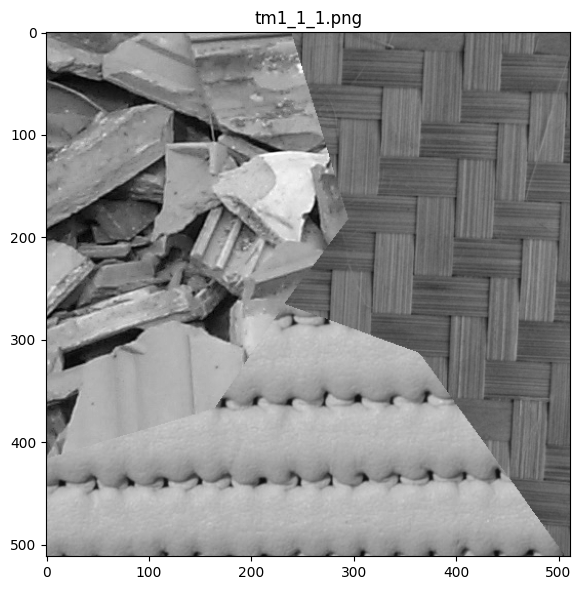

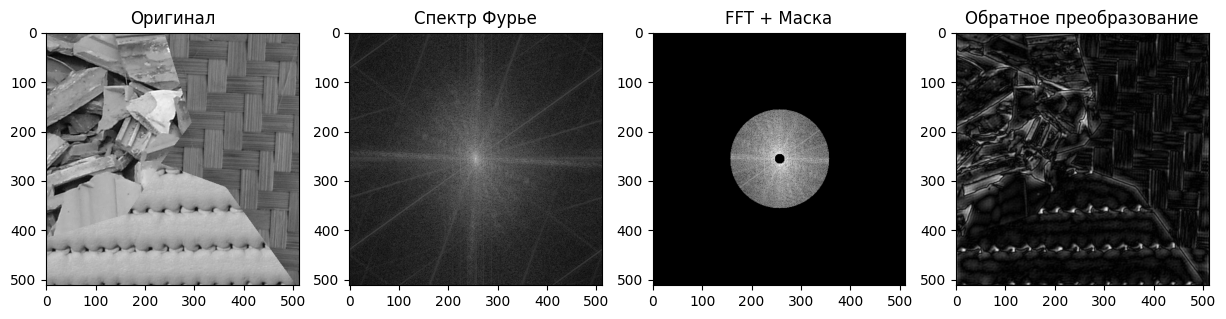

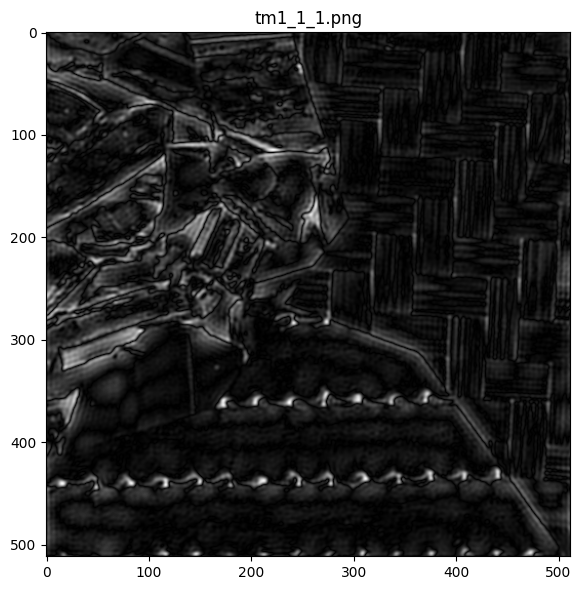

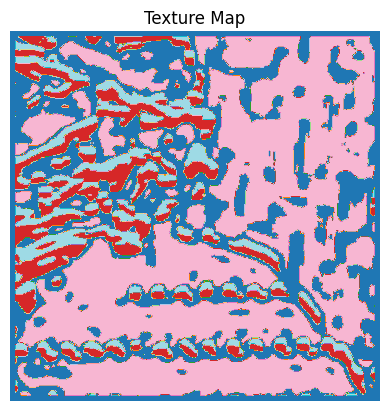

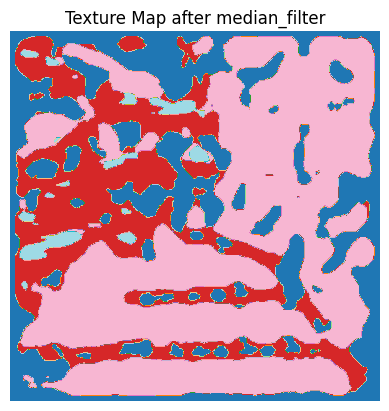

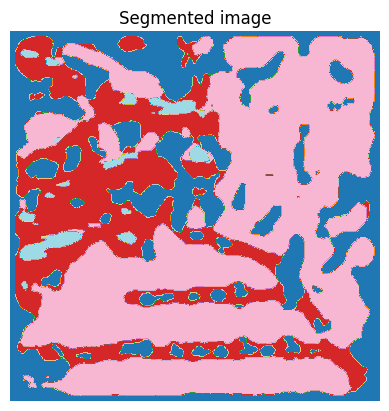

<ipython-input-192-0b9da8d10eef>:213: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  segmented_image = closing(segmented_image, square(closing_width))


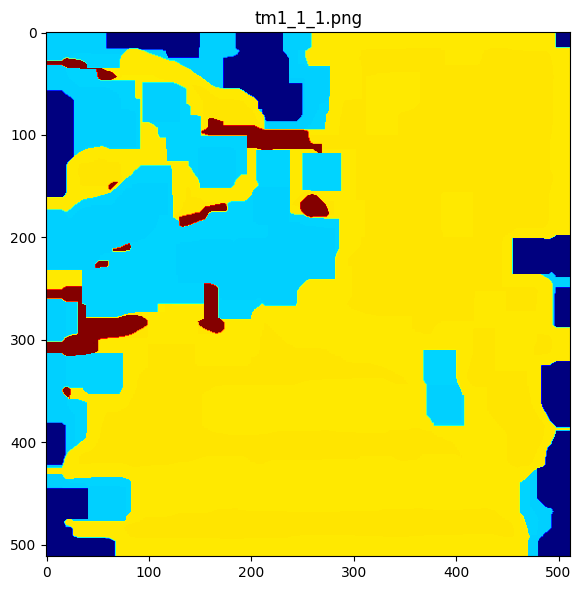

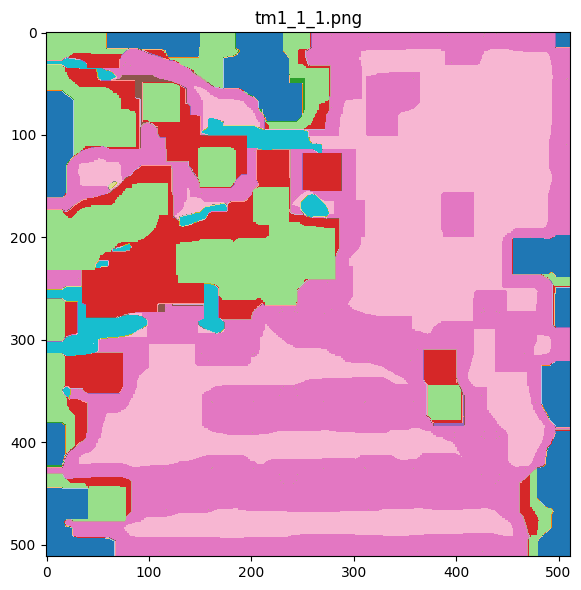

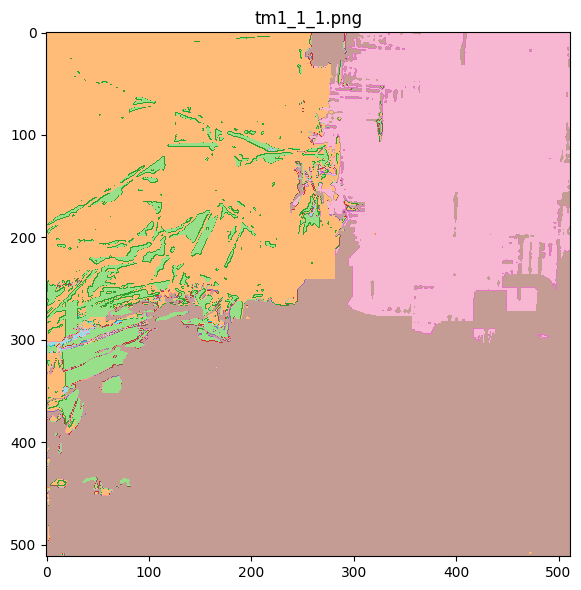

In [194]:
def main(directory):
    # Load images from the specified directory
    images: dict = TextureSegmentation.load_images(directory)

    # Display the images
    rows, cols, figsize = 1, 1, (8, 6)
    TextureSegmentation.show_images(images, rows=rows, cols=cols, figsize=figsize, cmap='gray')

    # Preprocess images
    resize_shape = None
    convert_to_gray = True
    normalize = True
    sigma = None
    apply_edge_detection = False
    apply_wavelet = False
    wavelet = 'db3'
    wavelet_level = 5
    apply_fourier_transform = True
    radius_out = 100
    radius_in = 10
    for key, image in images.items():
        images[key] = TextureSegmentation.preprocess_image(image,
                                                           resize_shape=resize_shape,
                                                           convert_to_gray=convert_to_gray,
                                                           normalize=normalize,
                                                           sigma=sigma,
                                                           apply_edge_detection=apply_edge_detection,
                                                           apply_wavelet=apply_wavelet,
                                                           wavelet=wavelet,
                                                           wavelet_level=wavelet_level,
                                                           apply_fourier_transform=apply_fourier_transform,
                                                           radius_out=radius_out,
                                                           radius_in=radius_in)

    # Display the preprocessed images
    TextureSegmentation.show_images(images, rows=rows, cols=cols, figsize=figsize, cmap='gray')

    # Extract patches from the preprocessed images
    patches = dict()
    patch_size = (15, 15)
    for key, image in images.items():
        patches[key] = TextureSegmentation.extract_patches(image, patch_size=patch_size)

    # Cluster patches to find PRP (Principal Representative Patterns)
    max_clusters = 4
    prp_centroids, optimal_clusters = TextureSegmentation.cluster_patches(patches,
                                                                          max_clusters=max_clusters,
                                                                          find_optimal_clusters=False)

    # Segment the images by extracting texture features and using the Mumford-Shah
    segmented_images, edges = dict(), dict()
    gamma = 1.0
    median_filter_size, closing_width = 25, 30
    iterations, tol, alpha, beta, epsilon = 1, 0.1, 1000, -0.1, 0.01
    for key, image in images.items():
        segmented_images[key], edges[key] = TextureSegmentation.segmentation(image, prp_centroids,
                                                                            patch_size=patch_size,
                                                                            gamma=gamma,
                                                                            median_filter_size=median_filter_size,
                                                                            iterations=iterations,
                                                                            alpha=alpha, beta=beta,
                                                                            epsilon=epsilon,
                                                                            closing_width=closing_width)

    # Display the segmented images and edges
    TextureSegmentation.show_images(segmented_images, figsize=figsize, rows=rows, cols=cols, cmap='jet')
    # TextureSegmentation.show_images(edges, figsize=figsize, rows=rows, cols=cols, cmap=None)

    # Assign labels to the segmented images
    labels = dict()
    for key, segmented_image in segmented_images.items():
        labels[key] = TextureSegmentation.assign_labels(segmented_image)

    # Display the labels
    TextureSegmentation.show_images(labels, figsize=figsize, rows=rows, cols=cols, cmap='tab20')

    # Postprocess images using CRF
    postprocessed_images = dict()
    gt_prob = 0.7
    q_iterations = 10
    sxy_gaussian, compat_gaussian, sxy_bilateral, compat_bilateral, srgb_bilateral = 0.01, 0.01, 60, 10, 20
    for key, segmented_image in segmented_images.items():
        n_labels = labels[key].max() + 1
        postprocessed_images[key] = TextureSegmentation.postprocess_segmentation(images[key], labels[key], n_labels,
                                                                                 gt_prob=gt_prob,
                                                                                 q_iterations=q_iterations,
                                                                                 sxy_gaussian=sxy_gaussian,
                                                                                 compat_gaussian=compat_gaussian,
                                                                                 sxy_bilateral=sxy_bilateral,
                                                                                 compat_bilateral=compat_bilateral,
                                                                                 srgb_bilateral=srgb_bilateral)

    # Display the postprocessed images
    TextureSegmentation.show_images(postprocessed_images, figsize=figsize, rows=rows, cols=cols, cmap='tab20')

    # Save the segmented images to the output directory
    # TextureSegmantation.save_segmented_images('output', {})

if __name__ == '__main__':
    directory = 'data/'
    main(directory)